In [1]:
import csv
import math
import time
import warnings
import operator
import statistics
import requests
import json
import seaborn as sns
import pandas as pd
import numpy as np
import geopy.distance
import matplotlib.pyplot as plt

from dateutil.parser import parse
from datetime import datetime
from datetime import date, timedelta
from scipy import stats
from IPython.display import display_html
from multiprocessing import Pool
from sklearn.model_selection import train_test_split
from google.cloud import storage

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
%matplotlib inline

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:.2f}'.format

In [42]:
df_ads = pd.read_csv('gs://aes-analytics-0002-curated/Outage_Restoration/Historical_Data/Master_Dataset/OMS_IPL_OUTAGE_BASE_11232020.csv', index_col=0)
df_ads = df_ads[df_ads['TTR'] <= 3000]
df_ads = df_ads[df_ads['TTR'] >= 30]
df_ads.reset_index(drop=True, inplace=True)

In [43]:
print(list(df_ads.columns))
print('\n')
print(list(df_ads.shape))
df_ads.head()

['OUTAGE_ID', 'INCIDENT_ID', 'STRCTUR_NO', 'EVENT', 'CREATION_DATETIME', 'ENERGIZED_DATETIME', 'CIRCT_ID', 'DNI_EQUIP_TYPE', 'SUBST_ID', 'CALL_QTY', 'DOWNSTREAM_CUST_QTY', 'KEY_CUST_QTY', 'ETR_DATETIME', 'CUST_QTY', 'DAY_FLAG', 'TTR', 'POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG', 'EMERGENCY_CLUE_FLG', 'POWER_OUT_CLUE_FLG', 'OPEN_DEVICE_CLUE_FLG', 'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG', 'IVR_CLUE_FLG', 'EQUIPMENT_CLUE_FLG', 'TRANSFORMER_CLUE_FLG', 'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG', 'WEATHER_CAUSE_FLG', 'WEATHER_COLD_CAUSE_FLG', 'PUBLIC_CAUSE_FLG', 'WEATHER_LIGHTNING_CAUSE_FLG', 'WEATHER__SNOW_CAUSE_FLG', 'WEATHER__WIND_CAUSE_FLG', 'WEATHER__HEAT_CAUSE_FLG', 'CUST_REQUEST_CAUSE_FLG', 'WEATHER__FLOOD_CAUSE_FLG', 'STREET_CAUSE_FLG', 'SUBSTATION_CAUSE_FLG', 'TREE_CAUSE_FLG', 'MISCELLANEOUS_CAUSE_FLG', 'NO_CAUSE_FLG', 'PLANNED_CAUSE_FLG', 'NO_OUTAGE_CAUSE_FLG', 'FUSE_OCCURN_FLG', 'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 'TRANSFORMER_OCCURN_FLG', 'METER_OCCURN_FLG', 'SERVICE_OCCU

,OUTAGE_ID,INCIDENT_ID,STRCTUR_NO,EVENT,CREATION_DATETIME,ENERGIZED_DATETIME,CIRCT_ID,DNI_EQUIP_TYPE,SUBST_ID,CALL_QTY,DOWNSTREAM_CUST_QTY,KEY_CUST_QTY,ETR_DATETIME,CUST_QTY,DAY_FLAG,TTR,POLE_CLUE_FLG,PART_LIGHT_CLUE_FLG,EMERGENCY_CLUE_FLG,POWER_OUT_CLUE_FLG,OPEN_DEVICE_CLUE_FLG,TREE_CLUE_FLG,WIRE_DOWN_CLUE_FLG,IVR_CLUE_FLG,EQUIPMENT_CLUE_FLG,TRANSFORMER_CLUE_FLG,OH_CAUSE_FLG,UG_CAUSE_FLG,ANIMAL_CAUSE_FLG,WEATHER_CAUSE_FLG,WEATHER_COLD_CAUSE_FLG,PUBLIC_CAUSE_FLG,WEATHER_LIGHTNING_CAUSE_FLG,WEATHER__SNOW_CAUSE_FLG,WEATHER__WIND_CAUSE_FLG,WEATHER__HEAT_CAUSE_FLG,CUST_REQUEST_CAUSE_FLG,WEATHER__FLOOD_CAUSE_FLG,STREET_CAUSE_FLG,SUBSTATION_CAUSE_FLG,TREE_CAUSE_FLG,MISCELLANEOUS_CAUSE_FLG,NO_CAUSE_FLG,PLANNED_CAUSE_FLG,NO_OUTAGE_CAUSE_FLG,FUSE_OCCURN_FLG,CUST_EQUIP_OCCURN_FLG,POLE_OCCURN_FLG,TRANSFORMER_OCCURN_FLG,METER_OCCURN_FLG,SERVICE_OCCURN_FLG,CABLE_OCCURN_FLG,ST_OCCURN_FLG,FIRE_OCCURN_FLG,FOUND_OPEN_OCCURN_FLG,PUBLIC_SAFETY_OCCURN_FLG,WIRE_OCCURN_FLG,SWITCH_OCCURN_FLG,REGULATOR_OCCURN_FLG,CUTOUT_OCCURN_FLG,CAP_BANK_OCCURN_FLG,RECLOSER_OCCURN_FLG,OH_OCCURN_FLG,PRIORITY_VAL_1.0,PRIORITY_VAL_2.0,PRIORITY_VAL_3.0,PRIORITY_VAL_5.0,CITY_NAM,LAT,LONG,ZONE,PRIM_OCCURN_DESC,SECO_OCCURN_DESC,TERT_OCCURN_DESC,PRIM_CAUSE_DESC,SECO_CAUSE_DESC,COMMENT_TEXT,NO_OF_POWER_OUT_CLUE_PER_DAY,NO_OF_OPEN_DEVICE_CLUE_PER_DAY,NO_OF_IVR_CLUE_PER_DAY,NO_OF_ANIMAL_CAUSE_PER_DAY,NO_OF_WIRE_OCCURN_PER_DAY,Marker_Location,Hour_Sin,Hour_Cos,RANK_SUBSEQUENT_OUTAGES,LIVE_OUTAGE,Outages_in_last_1hr,Outages_in_last_2hr,Outages_in_last_3hr,Outages_in_last_4hr,Outages_in_last_5hr,Outages_in_last_6hr,Outages_in_last_7hr,Outages_in_last_8hr,Outages_in_last_9hr,Outages_in_last_10hr,Weekday,Weekend_flag,Live_outage_group,Priority_Customer_Qty,Dis_From_Live_Centriod_div_Cust_qty,Priority_Dist_Customer_Qty,Dispatch_Location,cldCvrAvg,cldCvrMax,cldCvrMin,dewPtAvg,dewPtMax,dewPtMin,feelsLikeAvg,feelsLikeMax,feelsLikeMin,heatIndexAvg,heatIndexMax,heatIndexMin,mslPresAvg,mslPresMax,mslPresMin,precip,radSolarAvg,radSolarMax,radSolarTot,relHumAvg,relHumMax,relHumMin,sfcPresAvg,sfcPresMax,sfcPresMin,snowfall,spcHumAvg,spcHumMax,spcHumMin,tempAvg,tempMax,tempMin,wetBulbAvg,wetBulbMax,wetBulbMin,windChillAvg,windChillMax,windChillMin,windDir100mAvg,windDir80mAvg,windDirAvg,windSpd100mAvg,windSpd100mMax,windSpd100mMin,windSpd80mAvg,windSpd80mMax,windSpd80mMin,windSpdAvg,windSpdMax,windSpdMin,tempRange,windSpdRange,sfcPresRange,cldCvrRange,relHumRange,relHumRatio,sfcPresRatio,Active_no_of_trucks_per_day,UNIT,REPAIR_REMARK
0,2001309379,2000383864.00,494-B/403,BLUE SKY,2007-01-01 08:16:14,2007-01-01 10:04:24,1252.00,FUSE,125.00,1,5.00,0.00,2007-01-01 11:46:14,5.00,True,108.17,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,INDIANAPOLIS,39.78,-86.27,ZONE4,FUSE,FUSE BLOWN,NaN,O.H. EQUIPMENT,BAD ARRESTOR,contact # 484-1600 ext 804. gs,7,1,5,2,1,Marker10,0.87,-0.50,2.00,0,0,0,0,0,1,1,1,1,1,1,Monday,False,2,2.00,1.05,2.00,MILL,93.00,100.00,43.00,33.20,39.10,29.50,29.60,36.30,23.50,37.90,43.20,34.00,1016.90,1026.20,1009.30,0.00,29.00,127.20,695.30,83.00,90.00,79.00,986.80,995.70,980.10,0.00,4.10,5.20,3.50,37.90,43.20,34.00,36.00,41.30,32.20,29.60,36.30,23.50,270.00,271.00,268.00,16.80,20.20,8.70,16.90,20.50,8.80,14.40,17.80,6.70,9.20,11.10,15.60,57.00,11.00,1.14,1.02,nan,NaN,NaN
1,2001309379,2000383864.00,494-B/403,BLUE SKY,2007-01-01 08:16:14,2007-01-01 10:04:24,1252.00,FUSE,125.00,1,5.00,0.00,2007-01-01 11:46:14,5.00,True,108.17,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,INDIANAPOLI

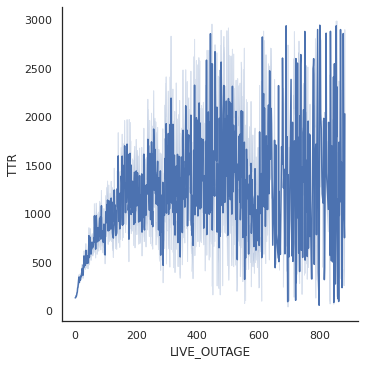

In [44]:
sns.set(rc={'figure.figsize':(16,12)})
sns.set_style("white")

sns.relplot(x="LIVE_OUTAGE", y="TTR", data=df_ads, kind='line')

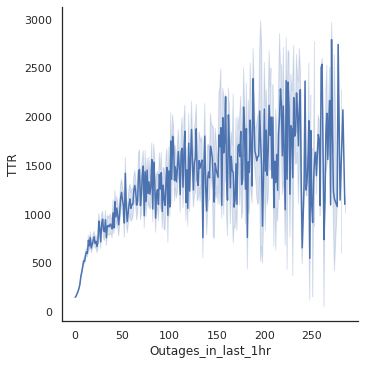

In [57]:
sns.relplot(x="Outages_in_last_1hr", y="TTR", data=df_ads, kind='line')

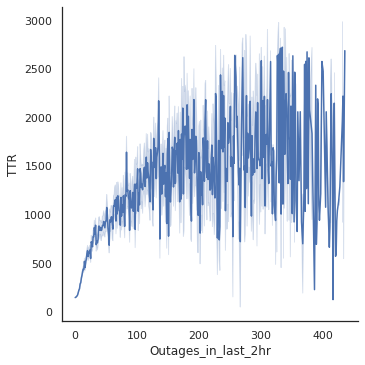

In [47]:
sns.relplot(x="Outages_in_last_2hr", y="TTR", data=df_ads, kind='line')

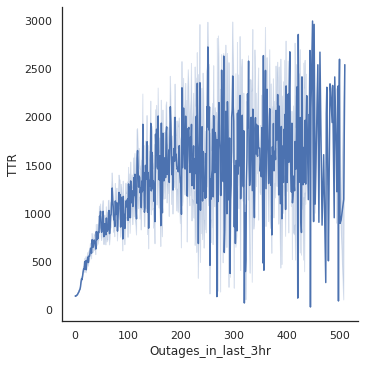

In [48]:
sns.relplot(x="Outages_in_last_3hr", y="TTR", data=df_ads, kind='line')

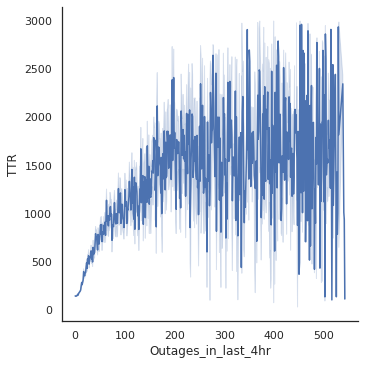

In [49]:
sns.relplot(x="Outages_in_last_4hr", y="TTR", data=df_ads, kind='line')

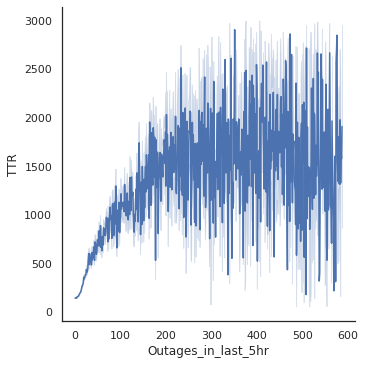

In [50]:
sns.relplot(x="Outages_in_last_5hr", y="TTR", data=df_ads, kind='line')

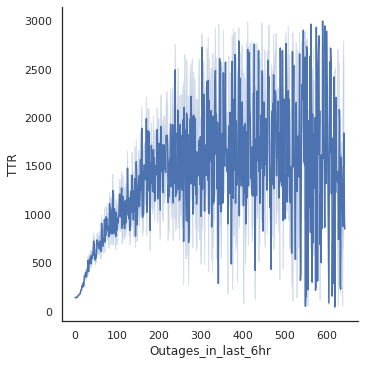

In [51]:
sns.relplot(x="Outages_in_last_6hr", y="TTR", data=df_ads, kind='line')

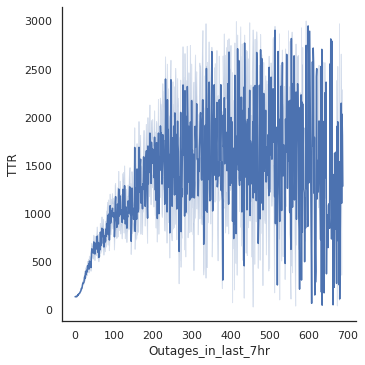

In [52]:
sns.relplot(x="Outages_in_last_7hr", y="TTR", data=df_ads, kind='line')

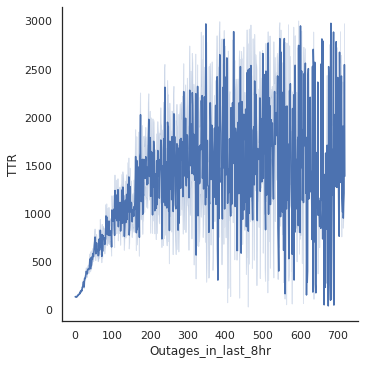

In [53]:
sns.relplot(x="Outages_in_last_8hr", y="TTR", data=df_ads, kind='line')

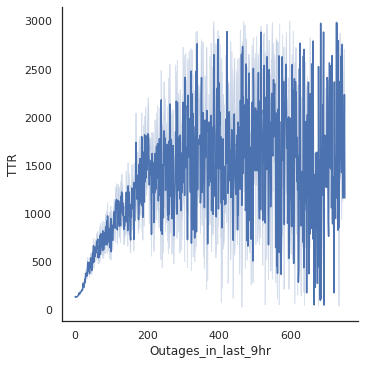

In [54]:
sns.relplot(x="Outages_in_last_9hr", y="TTR", data=df_ads, kind='line')

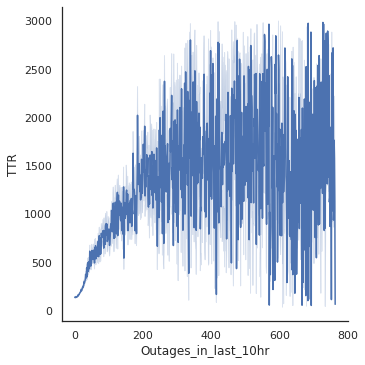

In [55]:
sns.relplot(x="Outages_in_last_10hr", y="TTR", data=df_ads, kind='line')